In [1]:
%pylab inline
import nltk
import gensim
import torch

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(10, 8)

In [3]:
import wikipedia

In [4]:
wikipedia.set_lang("pt")
text = wikipedia.page("Alan_Turing").content

In [5]:
corpus_text = []

stop_words = nltk.corpus.stopwords.words("portuguese") + nltk.corpus.stopwords.words("english")

for i in text.splitlines():
    clean_text = gensim.utils.simple_preprocess(i)
    clean_text = [i for i in clean_text if i not in stop_words]
    for ct in clean_text:
        corpus_text.append(ct)

In [6]:
corpus_text[:5]

['alan', 'mathison', 'turing', 'obe', 'paddington']

In [7]:
word2id, id2word = {}, {}

uniques = set(corpus_text)

count_id = 0
for word in uniques:
    word2id[word] = count_id
    id2word[count_id] = word
    count_id += 1

In [8]:
id2word[23]

'automático'

In [9]:
len(uniques), len(corpus_text)

(623, 930)

In [10]:
import numpy as np

In [11]:
window = 2
pair_ids = []

text_size = len(corpus_text)

corpus_text = np.array(corpus_text)
mask = np.array([i for i in range(-window, window+1) if i is not 0])

for center_word in range(window, text_size-window):
    center_word_id = word2id[corpus_text[center_word]]
    context_words = [word2id[i] for i in corpus_text[mask + center_word]]
    
    pair_ids.append([context_words, center_word_id])

In [12]:
from IPython.display import Markdown

In [13]:
ex_out = "|contexto | central | contexto | central |\n|--|--|--|--|\n"
for i in range(95, 106):
    w0, w1 = pair_ids[i]
    ex_out += f"|{w0} | {w1} | {[id2word[w] for w in w0]} | {id2word[w1]}|\n"

Markdown(ex_out)

|contexto | central | contexto | central |
|--|--|--|--|
|[495, 152, 500, 77] | 389 | ['armazenado', 'ace', 'turing', 'interessou'] | posteriormente|
|[152, 389, 77, 424] | 500 | ['ace', 'posteriormente', 'interessou', 'química'] | turing|
|[389, 500, 424, 10] | 77 | ['posteriormente', 'turing', 'química', 'escreveu'] | interessou|
|[500, 77, 10, 55] | 424 | ['turing', 'interessou', 'escreveu', 'artigo'] | química|
|[77, 424, 55, 394] | 10 | ['interessou', 'química', 'artigo', 'sobre'] | escreveu|
|[424, 10, 394, 348] | 55 | ['química', 'escreveu', 'sobre', 'base'] | artigo|
|[10, 55, 348, 424] | 394 | ['escreveu', 'artigo', 'base', 'química'] | sobre|
|[55, 394, 424, 548] | 348 | ['artigo', 'sobre', 'química', 'morfogênese'] | base|
|[394, 348, 548, 294] | 424 | ['sobre', 'base', 'morfogênese', 'previu'] | química|
|[348, 424, 294, 562] | 548 | ['base', 'química', 'previu', 'reações'] | morfogênese|
|[424, 548, 562, 151] | 294 | ['química', 'morfogênese', 'reações', 'químicas'] | previu|


In [31]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, emb_size, context_size):
        super(CBOW, self).__init__()
        
        self.embeddings = torch.nn.Embedding(vocab_size, emb_size)
        
        self.linear0 =  torch.nn.Linear(2*emb_size*context_size, 512)
        self.linear1 = torch.nn.Linear(512, vocab_size)

        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.embeddings(x).view(1, -1)

        out = self.linear0(out)
        out = self.linear1(out)
        
        out = self.log_softmax(out)
        return out
    
    def get_word_emb(self, word_id):
        word = torch.LongTensor([word_id])
        return self.embeddings(word).view(1, -1)

In [47]:
cbow = CBOW(len(uniques), 10, 2)

In [48]:
teste_data = torch.LongTensor(pair_ids[100][0])
target_data = torch.LongTensor(pair_ids[100][1])
res = cbow(teste_data).argmax().item()
id2word[res]

'introduziu'

In [ ]:
nll_loss = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

indexes = np.arange(len(pair_ids))
losses = []
for epoch in range(51):
    np.random.shuffle(indexes)
    for index in indexes:
        context, target = pair_ids[index]
        optimizer.zero_grad()
        cbow.zero_grad()
        
        X = torch.LongTensor(context)
        Y = torch.LongTensor([target])
        out_prob = cbow(X)
        loss = nll_loss(out_prob, Y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    if epoch %10 == 0:
        print(f"{epoch:<2} - {loss.item():.3f}")

0  - 6.626
10 - 3.307


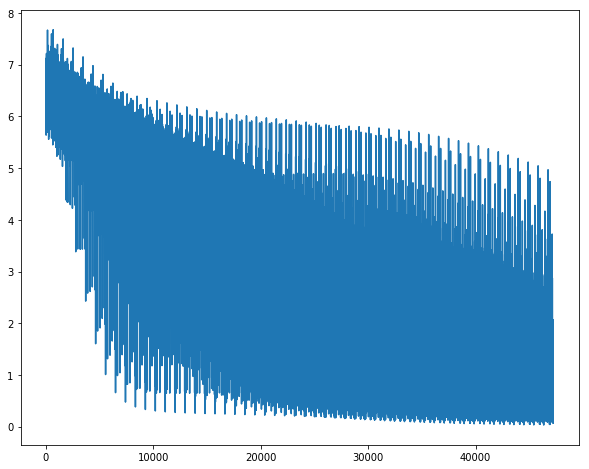

In [35]:
plot(losses)

In [36]:
_pos = 28
teste_data = torch.LongTensor(pair_ids[_pos][0])
target_data = torch.LongTensor(pair_ids[_pos][1])
res = cbow(teste_data).argmax().item()
print(f"data:{[id2word[i] for i in pair_ids[_pos][0]]} | target: {id2word[pair_ids[_pos][1]]}")
print(f"{id2word[res]}")


data:['papel', 'importante', 'computador', 'moderno'] | target: criação
criação


In [37]:
cbow.get_word_emb(_pos).detach().numpy()

array([[ 1.4503645 , -0.00673518,  1.8622327 , -0.88099694,  0.0185612 ,
        -0.22558688, -0.4932858 ,  0.44633344, -0.3284861 ,  0.27222428]],
      dtype=float32)

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [39]:
dataf = pd.DataFrame({
    "words":list(uniques),
    "id": [word2id[i] for i in uniques],
    "emb": [cbow.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],
    "x" : [0]*len(uniques),
    "y": [0]*len(uniques)
})

In [40]:
dataf.head()

,words,id,emb,x,y
0,criados,0,"[-0.7369466, -0.8059866, 1.0027227, 0.64112455...",0,0
1,anos,1,"[0.2901197, 2.4729302, -0.21075082, -0.9001942...",0,0
2,tratado,2,"[0.113352485, -0.06995451, 0.8632336, 0.297103...",0,0
3,morto,3,"[0.3952126, 0.76867807, -0.8826657, -1.0946348...",0,0
4,desculpa,4,"[0.66456705, -0.15295699, -1.3683532, -0.33759...",0,0


In [41]:
pca = PCA(n_components=2)
a = np.array([cbow.get_word_emb(word2id[i]).detach().numpy()[0] for i in uniques],)
XY = pca.fit_transform(a)

In [42]:
dataf["x"] = XY[:, 0]
dataf["y"] = XY[:, 1]
dataf.head()

,words,id,emb,x,y
0,criados,0,"[-0.7369466, -0.8059866, 1.0027227, 0.64112455...",-0.183116,1.180047
1,anos,1,"[0.2901197, 2.4729302, -0.21075082, -0.9001942...",-0.496510,-0.243766
2,tratado,2,"[0.113352485, -0.06995451, 0.8632336, 0.297103...",1.819824,0.216353
3,morto,3,"[0.3952126, 0.76867807, -0.8826657, -1.0946348...",-1.145312,-1.028603
4,desculpa,4,"[0.66456705, -0.15295699, -1.3683532, -0.33759...",-0.163904,-1.456896


In [43]:
import altair as alt

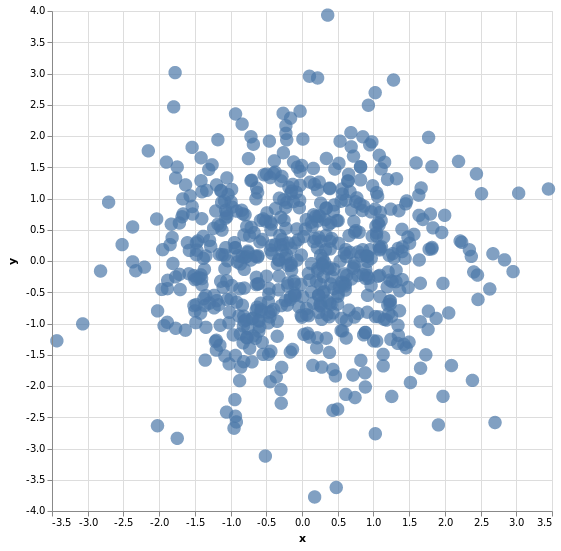

In [44]:
alt.themes.enable('opaque')
base = alt.Chart(dataf).properties(
        width=500,
        height=500
    )

base.mark_circle(size=180).encode(x="x", y="y", tooltip="words")